# **SCDAA Coursework 2024-2025**
---

In [138]:
import utils.exercises1_1 as ex1_1
import utils.exercises1_2 as ex1_2
import utils.exercises2_1 as ex2_1
import matplotlib.pyplot as plt
import importlib
import torch
import numpy as np

## **Exercise 1.1 (Solving LQR using from Ricattic ODE)**

Write a class which:
1. Can be initialised with the matrices specifying the LQR problem and $T > 0$ and a time grid (numpy array or torch tensor). 
2. Has a method which will solve (approximate) the associated Ricatti ODE on this time grid. 
3. Has a method that, given one torch 1d-tensor (for time) and another torch 2d-tensor (for space), will return a 1d-torch tensor the control problem value $v(t, x)$ for the given $t, x$. If t is not on the time grid use $t_n$ which belongs to the grid and is the the nearest to $t$ (or the biggest $t_n$ smaller than $t$). 
4. Has a method that, given one torch 1d-tensor (for time) and another torch 2d-tensor (for space), will return a 2d-torch tensor with entries being the optimal Markov control function for the given $t, x$ i.e..

In [139]:
importlib.reload(ex1_1)

# (1)Initialize matrix values
H = torch.tensor([[1.0, 1.0], [0.0, 1.0]]) * 0.5
M = torch.tensor([[1.0, 1.0], [0.0, 1.0]])
sigma = torch.eye(2) * 0.5
C = torch.tensor([[1.0, 0.1], [0.1, 1.0]]) * 1.0
D = torch.tensor([[1.0, 0.1], [0.1, 1.0]]) * 0.1
R = torch.tensor([[1.0, 0.3], [0.3, 1.0]]) * 10.0
T = 0.5
N = 100

# (2)Initialize LQR function (include solving the associated Ricatti ODE)
lqr = ex1_1.LQR(H, M, C, D, R, sigma, T, N)

# Initialize t and x
t0 = 0
x0 = torch.tensor([1.0, 1.0])

# (3)Solve the value function v(t, x)
v = lqr.value_function(t0, x0)
print("Value function v(t, x):", v.item())

# (4)Solve the optimal control a(t, x)
a = lqr.optimal_control(t0, x0)
print("Optimal control a(t, x):", a.tolist())

Value function v(t, x): 0.7838265895843506
Optimal control a(t, x): [-1.2770085334777832, -5.199576377868652]


## **Exercise 1.2 (LQR MC checks)**

Run a Monte Carlo simulation of the system with the optimal solution you have obtained and ensure that you’re converging to the optimal value function you obtained in Exercise 1.1. You should check at least the case $t = 0$ and $x = (1, 1)$ and say $x = (2, 2)$ but of course few more would do no harm. In principle the value function is defined on the whole of $[0, T] \times R^2$ so we should check many more points against e.g. supremum norm but running the tests on some grid in this will get very computationally heavy very fast. 

Fix $T = 1/2$. In particular what we want to see:
1. With number of Conte Carlo samples large (e.g. 10000) vary the number of time steps in your simulation, take $2^1$, $2^2$, . . . , $2^{11}$ and plot the error as a log-log plot. What is the expected convergence rate and what do you observe? 
2. With a number of time steps large e.g. 10000 vary the number of Monte-Carlo samples, take $2 \cdot 4^0$, $2 \cdot 4^1$, . . . , $2 \cdot 4^5$ and plot the error as a log-log plot. What is the expected convergence rate and what do you observe?

*Hint:* Let $a = a(t, x)$ denote the optimal control from Exercise 1.1. Once you’ve plugged this in (1) you get 
```math
dX_s = [HX_s + Ma(s, X_s)] ds + \sigma dW_s , \quad s \in [t, T] ,\quad X_t = x
```
To do a time discretisation fix $N \in \mathbb{N}$ (number of time steps); let $\tau := T/N$ be the time step. Assume from now that you’d only possible want to start the SDE at times $t_k = k\tau$ for some $k = 0, 1, . . . , N$. You have a choice of (at least) two schemes since you know $a(t, x) = −D^{−1}M_TS(t)x$.

Explicit: 
```math
X_{t_{n+1}}^{N} = X_{t_n}^{N} + \tau [HX_{t_n}^N − MD^{−1}M_TS(t_n)X_{t_n}^N )] + \sigma (W_{t_{n+1}}−W_{t_n} ), \quad n = k, . . . , N , \quad X_{t_k}^N = x . 
```
Implicit: 
```math
X_{t_{n+1}}^{N} = X_{t_{n+1}}^{N} + \tau [HX_{t_{n+1}}^N − MD^{−1}M_TS(t_{n+1})X_{t_{n+1}}^N )] + \sigma (W_{t_{n+1}}−W_{t_n} ), \quad n = k, . . . , N , \quad X_{t_k}^N = x . 
```

In [140]:
importlib.reload(ex1_2)

# Initialize matrix values
H = torch.tensor([[1.0, 1.0], [0.0, 1.0]]) * 0.5
M = torch.tensor([[1.0, 1.0], [0.0, 1.0]])
sigma = torch.eye(2) * 0.5
C = torch.tensor([[1.0, 0.1], [0.1, 1.0]]) * 1.0
D = torch.tensor([[1.0, 0.1], [0.1, 1.0]]) * 0.1
R = torch.tensor([[1.0, 0.3], [0.3, 1.0]]) * 10.0
T = 0.5

# Initialize t and x
t0 = 0
x0 = torch.tensor([1.0, 1.0])

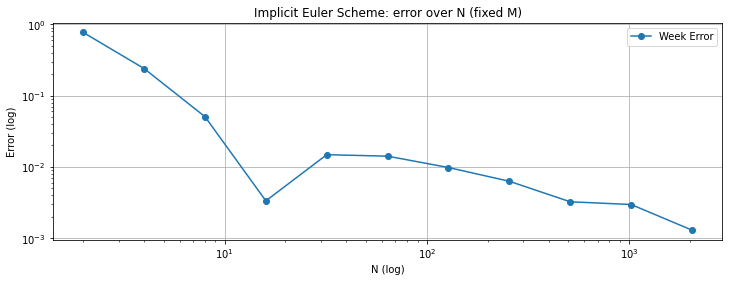


===== Convergence Rate Analysis =====
The slope of Error over N  = -0.75


In [141]:
importlib.reload(ex1_2)

# (1) Fixed M, change N, observe the error
M_samples_fixed = 10000
N_step_list = [2 ** k for k in range(1, 12)]  # 2^1 到 2^11

# Calculate the error over N
err_N = ex1_2.error_on_N(H, M, C, D, R, sigma, T, M_samples_fixed, N_step_list, v, t0, x0)

# Plot the log-log Plot
ex1_2.loglog_plot(N_step_list, err_N, 'M', 'N')

# Calculate the convergence rate
slope_N = ex1_2.compute_error_slope(np.array(N_step_list), np.array(err_N))
print("\n===== Convergence Rate Analysis =====")
print(f"The slope of Error over N  = {slope_N:.2f}")

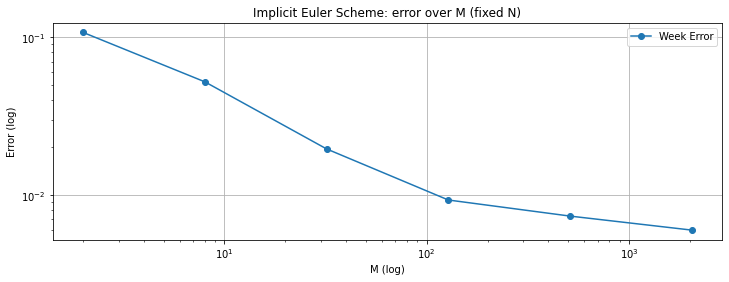


===== Convergence Rate Analysis =====
The slope of Error over M  = -0.43


In [142]:
importlib.reload(ex1_2)

# (2) Fixed N, change M, observe the error
N_fixed = 10000
M_samples_list = [2 * 4 ** k for k in range(6)]

# Calculate the error over M
err_M = ex1_2.error_on_M(H, M, C, D, R, sigma, T, N_fixed, M_samples_list, v, t0, x0)

# Plot the log-log Plot
ex1_2.loglog_plot(M_samples_list, err_M, 'N', 'M')

# Calculate the convergence rate
slope_M = ex1_2.compute_error_slope(np.array(M_samples_list), np.array(err_M))
print("\n===== Convergence Rate Analysis =====")
print(f"The slope of Error over M  = {slope_M:.2f}")

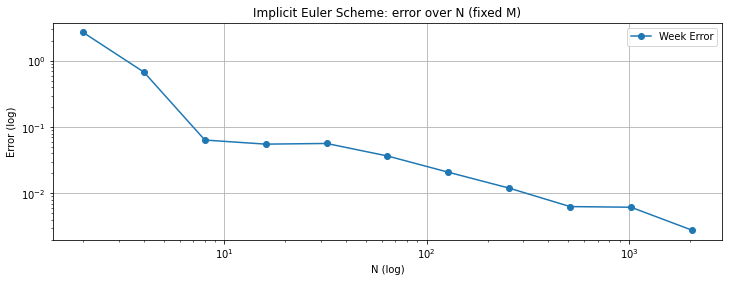


===== Convergence Rate Analysis =====
The slope of Error over N  = -0.84


In [143]:
importlib.reload(ex1_2)
# Change the initial value of x
x1 = torch.tensor([2.0, 2.0])

# Solve the value function on x1
v1 = lqr.value_function(t0, x1)

# (1) Fixed M, change N, observe the error
M_samples_fixed = 10000
N_step_list = [2 ** k for k in range(1, 12)]  # 2^1 到 2^11

# Calculate the error over N
err_N = ex1_2.error_on_N(H, M, C, D, R, sigma, T, M_samples_fixed, N_step_list, v1, t0, x1)

# Plot the log-log Plot
ex1_2.loglog_plot(N_step_list, err_N, 'M', 'N')

# Calculate the convergence rate
slope_N = ex1_2.compute_error_slope(np.array(N_step_list), np.array(err_N))
print("\n===== Convergence Rate Analysis =====")
print(f"The slope of Error over N  = {slope_N:.2f}")

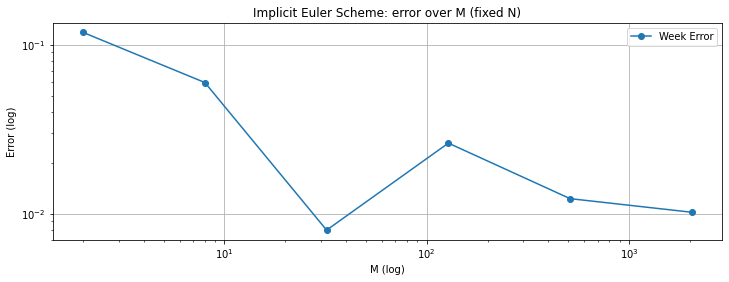


===== Convergence Rate Analysis =====
The slope of Error over M  = -0.33


In [144]:
importlib.reload(ex1_2)

# (2) Fixed N, change M, observe the error
N_fixed = 10000
M_samples_list = [2 * 4 ** k for k in range(6)]

# Calculate the error over M
err_M = ex1_2.error_on_M(H, M, C, D, R, sigma, T, N_fixed, M_samples_list, v1, t0, x1)

# Plot the log-log Plot
ex1_2.loglog_plot(M_samples_list, err_M, 'N', 'M')

# Calculate the convergence rate
slope_M = ex1_2.compute_error_slope(np.array(M_samples_list), np.array(err_M))
print("\n===== Convergence Rate Analysis =====")
print(f"The slope of Error over M  = {slope_M:.2f}")

# **Exercises 2.1 (Solving soft LQR)**

For the soft LQR problem introduced in [1] do the following. 

1. As Exercise 1.1 parts 1. and 2. with additional input $\tau$ and $\gamma$ (strength of entropic regularization and variance of prior normal density respectively). 
2. As Exercise 1.1 part 3. 
3. As Exercise 1.1 part 4. Note that the exact solution only gives you a distribution that you have to sample the actual action from. 
4. For the problem given in Figure 1 and taking $\tau$ = 0.1 and $\gamma$ = 10 run and plot the resulting four controlled trajectories for the strict LQR and relaxed LQR from four different starting points: [2, 2], [2, −2], [−2, −2], [−2, 2]. Note that you need to use the same samples to create the Brownian motion for both the strict and the relaxed problem to see something that’s comparable.

In [145]:
importlib.reload(ex2_1)

# (1)Initialize matrix values
H = torch.tensor([[1.0, 1.0], [0.0, 1.0]]) * 0.5
M = torch.tensor([[1.0, 1.0], [0.0, 1.0]])
sigma = torch.eye(2) * 0.5
C = torch.tensor([[1.0, 0.1], [0.1, 1.0]]) * 1.0
D = torch.tensor([[1.0, 0.1], [0.1, 1.0]]) * 0.1
R = torch.tensor([[1.0, 0.3], [0.3, 1.0]]) * 10.0
T = 1
N = 1000    # dt = T/N = 0.001

# Initialize additional input
tau = 10
gamma = 10

# Initialize soft LQR function (include solving the associated Ricatti ODE)
soft_lqr = ex2_1.Soft_LQR(H, M, C, D, R, sigma, T, N, tau, gamma)

# Initialize t and x
t0 = 0
x0 = torch.tensor([1.0, 1.0])

# (2)Solve the value function v(t, x)
v = soft_lqr.value_function(t0, x0)
print("Value function v(t, x):", v.item())

# (3)Solve the optimal control distribution pi(t, x)
control_dist = soft_lqr.optimal_control(t0, x0)

# Obtain the mean and convariance of the distribution
print("Optimal control mean μ(t, x):", control_dist.mean.tolist())
print("Optimal control covariance Σ_a:", control_dist.covariance_matrix.tolist())

# Sample a optimal control
sampled_control = control_dist.sample()
print("Sampled control a*(t, x):", sampled_control.tolist())

Value function v(t, x): 5.15438175201416
Optimal control mean μ(t, x): [-1.2593152523040771, -4.282013416290283]
Optimal control covariance Σ_a: [[1.5, 0.10000000894069672], [0.10000000894069672, 1.5]]
Sampled control a*(t, x): [-1.1260948181152344, -6.490705490112305]


/Users/zzzz/github/SCADD_Group8/utils/exercises2_1.py:68: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  integral, _ = quad(integrand, t, self.T)  # 使用数值积分计算积分项


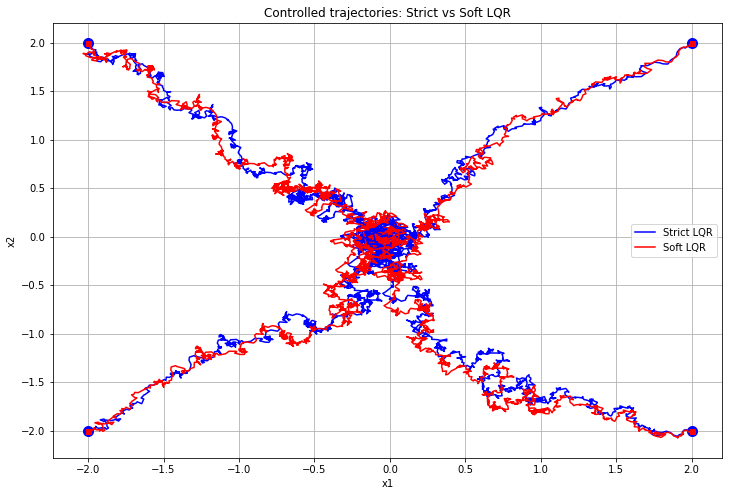

In [146]:
importlib.reload(ex1_1)
importlib.reload(ex2_1)

# (4)Initialize dW for strict lqr and soft lqr
dt = T/N
torch.manual_seed(1234)
dW = torch.randn(N, 2) * np.sqrt(dt)

# four initial states
initial_states = torch.tensor([[2.0, 2.0], [2.0, -2.0], [-2.0, -2.0], [-2.0, 2.0]])

# Initialize LQR function
lqr = ex1_1.LQR(H, M, C, D, R, sigma, T, N)

ex2_1.plot_x_trajectory(initial_states, lqr, soft_lqr, dW)

In [ ]:
#乱七八糟版第四题

import numpy as np
import torch
from torch.distributions.multivariate_normal import MultivariateNormal
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.integrate import solve_ivp, cumulative_trapezoid as cumtrapz


# ==========================================
# 1. Soft_LQR 类（Exercise 2 实现的代码）——改进版
# ==========================================
class Soft_LQR:
    def __init__(self, H, M, C, D, R, sigma, T, N, tau, gamma):
        """
        初始化 soft LQR 类
        参数同前，计算 S(t) 并提供最优值函数 v*(t,x)
        优化：预先计算积分项 I(t)=∫[t,T] tr(σσ^T S(r)) dr
        """
        self.H = H
        self.M = M
        self.C = C
        self.D = D
        self.R = R
        self.sigma = sigma
        self.T = T
        self.N = N
        self.time_grid = torch.linspace(0, T, N + 1)
        self.tau = tau
        self.gamma = gamma
        self.S_values = self.solve_riccati_ode()
        self.integral_values = self.precompute_integrals()

    def riccati_ode(self, t, S_flat):
        S = torch.tensor(S_flat, dtype=torch.float32).reshape(2, 2)
        D_term = self.D + self.tau / (2 * (self.gamma ** 2)) * torch.eye(2)
        S_dot = S.T @ self.M @ torch.linalg.inv(D_term) @ self.M.T @ S - self.H.T @ S - S @ self.H - self.C
        return S_dot.flatten()

    def solve_riccati_ode(self):
        S_T = self.R.flatten()
        indices = torch.arange(self.time_grid.size(0) - 1, -1, -1)
        time_grid_re = torch.index_select(self.time_grid, 0, indices)
        sol = solve_ivp(self.riccati_ode, [self.T, 0], S_T, t_eval=time_grid_re, atol=1e-10, rtol=1e-10)
        S_matrices = sol.y.T[::-1].reshape(-1, 2, 2)
        # 构造字典：key 为时间（浮点数），value 为 S 矩阵（numpy 数组）
        return dict(zip(tuple(self.time_grid.tolist()), S_matrices))

    def precompute_integrals(self):
        """
        对于每个时间点 t_i 在 time_grid 上，预先计算
         I(t_i) = ∫_{t_i}^{T} tr(σσ^T S(r)) dr
        使用 trapezoidal 规则进行数值积分。
        返回字典：key 为 t_i，value 为 I(t_i)（标量 float）
        """
        times = self.time_grid.numpy()  # shape (N+1,)
        # 计算每个时间点对应的 f(t)= tr(σσ^T S(t))
        f_vals = []
        for t in times:
            S_t = self.S_values[t]
            f_val = torch.trace(self.sigma @ self.sigma.T @ torch.tensor(S_t, dtype=torch.float32)).item()
            f_vals.append(f_val)
        f_vals = np.array(f_vals)
        dt = times[1] - times[0]
        # 使用 cumulative_trapezoid 求积分，并传入 initial=0 使得输出长度与输入一致
        cum_int = cumtrapz(f_vals[::-1], dx=dt, initial=0)[::-1]
        integral_dict = {t: I for t, I in zip(times, cum_int)}
        return integral_dict

    def get_nearest_S(self, t):
        nearest_t = self.time_grid[torch.argmin(torch.abs(self.time_grid - t))]
        return self.S_values[nearest_t.tolist()]

    def value_function(self, t, x):
        """
        计算 v*(t,x)= x^T S(t)x + I(t) + (T-t)*C_{D,tau,gamma}
        其中 I(t)=∫[t,T] tr(σσ^T S(r)) dr，
        C_{D,tau,gamma} = -tau * ln((tau/gamma^2)*sqrt(det((D+tau/(2*gamma^2)I)^{-1})))
        """
        S_t = self.get_nearest_S(t)
        S_t = torch.tensor(S_t, dtype=torch.float32)
        val = x.T @ S_t @ x

        # 使用预先计算的积分值
        times = self.time_grid.numpy()
        # 找到最接近 t 的时间点
        idx = np.argmin(np.abs(times - t))
        t_nearest = times[idx]
        val = val + self.integral_values[t_nearest]

        var_matrix = self.D + self.tau / (2 * (self.gamma ** 2)) * torch.eye(2)
        inv_matrix = torch.linalg.inv(var_matrix)
        det_matrix = torch.det(inv_matrix)
        C_const = - self.tau * torch.log((self.tau / self.gamma ** 2) * torch.sqrt(det_matrix))
        val = val + (self.T - t) * C_const
        return val

    def optimal_control(self, t, x):
        """
        返回最优控制分布： N( -inv(D+tau/(2*gamma^2)I) * M^T S(t)x, tau*(D+tau/(2*gamma^2)I) )
        """
        S_t = self.get_nearest_S(t)
        S_t = torch.tensor(S_t, dtype=torch.float32)
        inv_term = self.D + self.tau / (2 * (self.gamma ** 2)) * torch.eye(2)
        mean_control = -torch.linalg.inv(inv_term) @ self.M.T @ S_t @ x
        cov_control = self.tau * inv_term
        control_dist = MultivariateNormal(mean_control, cov_control)
        return control_dist


# ==========================================
# 2. Actor 策略：参数化为线性映射 θ (2x2矩阵)
# ==========================================
class Actor:
    def __init__(self, state_dim=2, action_dim=2):
        # 参数 theta 初始化为随机 2x2 矩阵（可学习）
        self.theta = torch.nn.Parameter(torch.randn(action_dim, state_dim, dtype=torch.float32))

    def get_action(self, x):
        """
        给定状态 x (2维列向量)，输出策略均值 μ = θ x，
        并 squeeze 成一维向量
        """
        return (self.theta @ x).squeeze()

    def get_distribution(self, x, cov):
        mu = self.get_action(x)
        return MultivariateNormal(mu, cov)


# ==========================================
# 3. 利用当前 actor 策略生成一条轨迹（用 Euler 离散化）
# ==========================================

    """
    输入：
      actor：当前策略（Actor 实例）
      H, M, sigma：系统矩阵（torch 张量）
      dt, T：时间步长和终止时间
      x0：初始状态（torch 列向量 shape (2,1)）
      cov：策略固定协方差（torch 张量，2x2）

    返回：
      traj: 状态列表 (每个元素为 2x1 tensor)
      log_probs: 列表，每步动作的 log 概率（标量 tensor）
      costs: 列表，每步即时代价 f = x^T C x + a^T D a （标量 tensor）
 """
def simulate_actor_episode(actor, H, M, sigma, dt, T, x0, cov):
    traj = [x0.detach().clone()]  # x0 的形状现在为 (2,)
    log_probs = []
    costs = []

    x = x0
    num_steps = int(T / dt)
    for _ in range(num_steps):
        # 1) 生成动作，a 的形状为 (2,)
        dist = actor.get_distribution(x, cov)
        a = dist.rsample()  # 不再 unsqueeze
        logp = dist.log_prob(a)
        log_probs.append(logp)

        # 2) 用 no_grad() 包裹环境更新和 cost 计算
        dt_tensor = torch.tensor(dt, dtype=torch.float32)
        with torch.no_grad():
            # 计算即时 cost，注意：x 和 a 均为 1D 向量，所以用 x @ A @ x
            cost = (x @ C_tensor @ x) + (a @ D_tensor @ a)
            costs.append(cost.item())
            # 生成噪声也为一维
            noise = torch.randn(2)
            # 状态更新：x、a、noise 均为形状 (2,)
            x = x + (H @ x + M @ a) * dt + sigma @ (noise * torch.sqrt(dt_tensor))

        # 3) 保存新的状态
        traj.append(x.detach().clone())

    return traj, log_probs, costs



# ==========================================
# 4. Actor-only 算法主训练函数
# ==========================================
def train_actor(num_episodes=500, dt=0.01, T=1.0, gamma_lr=1e-8):  # 默认学习率改为 1e-3
    # 固定环境参数（与 main() 中一致）
    H_np = np.array([[0.5, 0.5],
                     [0.0, 0.5]], dtype=np.float32)
    M_np = np.array([[1.0, 1.0],
                     [0.0, 1.0]], dtype=np.float32)
    sigma_np = np.eye(2, dtype=np.float32) * 0.5
    C_np = np.array([[1.0, 0.1],
                     [0.1, 1.0]], dtype=np.float32)
    D_np = np.array([[1.0, 0.1],
                     [0.1, 1.0]], dtype=np.float32) * 0.1
    R_terminal_np = np.array([[1.0, 0.3],
                              [0.3, 1.0]], dtype=np.float32) * 10.0
    tau = 0.1
    gamma_param = 10.0
    N_steps = int(T / dt)

    # 转换为 torch 张量
    H_tensor = torch.tensor(H_np)
    M_tensor = torch.tensor(M_np)
    sigma_tensor = torch.tensor(sigma_np)
    global C_tensor, D_tensor
    C_tensor = torch.tensor(C_np)
    D_tensor = torch.tensor(D_np)

    # 初始化 Soft_LQR
    soft_lqr = Soft_LQR(H_tensor, M_tensor, C_tensor, D_tensor, torch.tensor(R_terminal_np), sigma_tensor, T, N_steps,
                        tau, gamma_param)

    # 固定策略协方差
    var_matrix = D_tensor + tau / (2 * (gamma_param ** 2)) * torch.eye(2)
    cov_opt = tau * var_matrix

    # 初始化 Actor 和优化器
    actor = Actor(state_dim=2, action_dim=2)
    optimizer = torch.optim.AdamW([actor.theta], lr=gamma_lr, weight_decay=1e-4)  # 改用 AdamW

    # 定义初始状态生成函数
    def get_init_state():
    # 返回形状为 (2,) 的向量
        return torch.tensor([np.random.uniform(-2, 2), np.random.uniform(-2, 2)], dtype=torch.float32)


    error_list = []

    for ep in range(num_episodes):
        init_state = get_init_state()  # 随机初始状态
        traj, log_probs, costs = simulate_actor_episode(actor, H_tensor, M_tensor, sigma_tensor, dt, T, init_state,
                                                        cov_opt)

        # 计算 v* 和 delta_v
        v_star = [soft_lqr.value_function(i * dt, x) for i, x in enumerate(traj)]
        delta_v = [v_star[i + 1] - v_star[i] for i in range(len(v_star) - 1)]

        # 计算损失
        loss = 0
        for n in range(len(delta_v)):
    

         loss_term = log_probs[n] * delta_v[n] \
            + log_probs[n] * costs[n] * dt \
            + tau * (log_probs[n]**2) * dt
         loss -= loss_term
        loss = loss.sum()


        # 反向传播
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # 计算误差
        S0 = torch.tensor(soft_lqr.get_nearest_S(0), dtype=torch.float32)
        mu_star = -torch.linalg.inv(var_matrix) @ M_tensor.T @ S0 @ init_state
        mu_actor = actor.get_action(init_state)
        error = torch.norm(mu_actor - mu_star).item()
        error_list.append(error)

        # 打印日志
        if (ep + 1) % 50 == 0:
            print(f"Episode {ep + 1}/{num_episodes}, Loss: {loss.item():.4f}, Actor Mean Error: {error:.4f}")

    # 绘制误差曲线
    plt.figure(figsize=(8, 5))
    plt.plot(error_list)
    plt.xlabel("Episode")
    plt.ylabel("Actor Mean Error (||μ_actor - μ*||)")
    plt.title("Actor Learning: Mean Error vs Episodes")
    plt.grid(True)
    plt.show()

    return actor


# ==========================================
# 5. 运行 Actor-only 算法
# ==========================================
if __name__ == "__main__":
    trained_actor = train_actor(num_episodes=500)  


/tmp/ipykernel_11107/3498026217.py:90: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3683.)
  val = x.T @ S_t @ x


Episode 50/500, TotalLoss=-25.4876, MeanError=2.7088, logCost=-0.6908
Episode 100/500, TotalLoss=-205.4383, MeanError=6.6388, logCost=1.9818
Episode 150/500, TotalLoss=-128.1214, MeanError=6.9689, logCost=1.2219
Episode 200/500, TotalLoss=-94.4040, MeanError=7.2896, logCost=1.3676
Episode 250/500, TotalLoss=-224.6097, MeanError=6.3221, logCost=1.7849
Episode 300/500, TotalLoss=-4.5088, MeanError=5.7744, logCost=0.6608
Episode 350/500, TotalLoss=-109.1907, MeanError=3.7266, logCost=1.0349
Episode 400/500, TotalLoss=-123.7601, MeanError=6.1107, logCost=1.4675
Episode 450/500, TotalLoss=-169.8880, MeanError=4.7045, logCost=1.2181
Episode 500/500, TotalLoss=-93.5981, MeanError=7.5056, logCost=1.4971


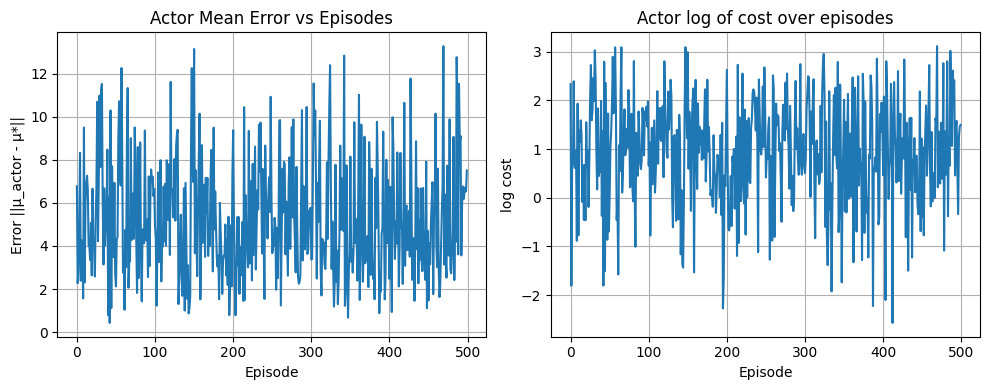

In [8]:
#log版第四题

import numpy as np
import torch
from torch.distributions.multivariate_normal import MultivariateNormal
import matplotlib.pyplot as plt
#from scipy.integrate import solve_ivp, cumulative_trapezoid as cumtrapz
# 用 cumtrapz 时
from scipy.integrate import solve_ivp, cumulative_trapezoid



# ==========================================
# 1. Soft_LQR 类：求解 S(t) 并提供最优值函数
# ==========================================
class Soft_LQR:
    def __init__(self, H, M, C, D, R, sigma, T, N, tau, gamma):
        """
        参考文献 [1] 中对 LQR 的松弛熵正则形式，使用 Riccati ODE 求解 S(t)，
        并预先计算积分 I(t) = ∫ tr(σσ^T S(r)) dr.
        """
        self.H = H
        self.M = M
        self.C = C
        self.D = D
        self.R = R
        self.sigma = sigma
        self.T = T
        self.N = N
        self.time_grid = torch.linspace(0, T, N + 1)
        self.tau = tau
        self.gamma = gamma
        self.S_values = self.solve_riccati_ode()
        self.integral_values = self.precompute_integrals()

    def riccati_ode(self, t, S_flat):
        """
        这是文献 [1] 对连续时间 Riccati 方程的实现。
        S_dot = (S^T M (D+...)^{-1} M^T S) - H^T S - S H - C
        """
        S = torch.tensor(S_flat, dtype=torch.float32).reshape(2, 2)
        D_term = self.D + self.tau / (2 * (self.gamma ** 2)) * torch.eye(2)
        S_dot = (S.T @ self.M @ torch.linalg.inv(D_term) @ self.M.T @ S
                 - self.H.T @ S - S @ self.H - self.C)
        return S_dot.flatten()

    def solve_riccati_ode(self):
        """
        从 T 往 0 反向求解 Riccati ODE，然后再翻转回来。
        """
        S_T = self.R.flatten()
        indices = torch.arange(self.time_grid.size(0) - 1, -1, -1)
        time_grid_re = torch.index_select(self.time_grid, 0, indices)
        sol = solve_ivp(
            self.riccati_ode, [self.T, 0], S_T, t_eval=time_grid_re,
            atol=1e-10, rtol=1e-10
        )
        S_matrices = sol.y.T[::-1].reshape(-1, 2, 2)
        return dict(zip(tuple(self.time_grid.tolist()), S_matrices))

    def precompute_integrals(self):
        """
        I(t_i) = ∫_{t_i}^{T} tr(σσ^T S(r)) dr
        使用累计梯形法数值近似。
        """
        times = self.time_grid.numpy()
        f_vals = []
        for t in times:
            S_t = self.S_values[t]
            f_val = torch.trace(self.sigma @ self.sigma.T @ torch.tensor(S_t, dtype=torch.float32)).item()
            f_vals.append(f_val)
        f_vals = np.array(f_vals)
        dt = times[1] - times[0]
        cum_int = cumulative_trapezoid(f_vals[::-1], dx=dt, initial=0)[::-1]
        integral_dict = {t: I for t, I in zip(times, cum_int)}
        return integral_dict

    def get_nearest_S(self, t):
        """
        给定一个 t，在离散网格 self.time_grid 上找最近的节点，并返回对应的 S(t)。
        """
        nearest_t = self.time_grid[torch.argmin(torch.abs(self.time_grid - t))]
        return self.S_values[nearest_t.tolist()]

    def value_function(self, t, x):
        """
        v*(t,x) = x^T S(t) x + I(t) + (T - t)*C_{D,tau,gamma}
        """
        S_t = torch.tensor(self.get_nearest_S(t), dtype=torch.float32)
        val = x.T @ S_t @ x

        times = self.time_grid.numpy()
        idx = np.argmin(np.abs(times - t))
        t_nearest = times[idx]
        val += self.integral_values[t_nearest]

        var_matrix = self.D + self.tau / (2 * (self.gamma ** 2)) * torch.eye(2)
        inv_matrix = torch.linalg.inv(var_matrix)
        det_matrix = torch.det(inv_matrix)
        C_const = - self.tau * torch.log((self.tau / self.gamma ** 2) * torch.sqrt(det_matrix))
        val += (self.T - t) * C_const
        return val

    def optimal_control(self, t, x):
        """
        返回理论最优分布：
          N( -inv(D+tau/(2 gamma^2)) M^T S(t) x,  tau*(D+tau/(2 gamma^2)) ).
        """
        S_t = torch.tensor(self.get_nearest_S(t), dtype=torch.float32)
        inv_term = self.D + self.tau / (2 * (self.gamma ** 2)) * torch.eye(2)
        mean_control = -torch.linalg.inv(inv_term) @ self.M.T @ S_t @ x
        cov_control = self.tau * inv_term
        return MultivariateNormal(mean_control, cov_control)

# ==========================================
# 2. Actor 策略：θ 是一个 2x2，可学习参数
# ==========================================
class Actor(torch.nn.Module):
    def __init__(self, state_dim=2, action_dim=2):
        """
        简单地将策略的均值参数化为 mu = θ x, 其中 θ 是 (2,2) 矩阵。
        协方差固定为 cov_opt。
        """
        super().__init__()
        self.theta = torch.nn.Parameter(torch.randn(action_dim, state_dim, dtype=torch.float32))

    def forward(self, x):
        # x 形状 (2,) -> mu 形状 (2,)
        mu = self.theta @ x
        return mu

    def get_distribution(self, x, cov):
        mu = self.forward(x)
        return MultivariateNormal(mu, cov)

# ==========================================
# 3. 采样一条轨迹 (Actor-only)
# ==========================================
@torch.no_grad()
def simulate_actor_episode(actor, H, M, sigma, dt, T, x0, cov):
    """
    - 不对环境状态演化做梯度，只对 log_prob(a) 可微
    - 但这里为了安全，使用 @torch.no_grad() 包裹整个函数；
      如果你想对 log_prob(a) 求梯度，需要先在函数里 .rsample() 在 no_grad() 外面。
    - 返回:
        traj: 每个离散时刻的状态
        log_probs: 动作的 log 概率 (可微/或先保存后 detach)
        costs: 每步 cost
    """
    traj = [x0.clone()]
    log_probs = []
    costs = []

    x = x0.clone()
    num_steps = int(T / dt)

    for _ in range(num_steps):
        # 1) 先脱离 no_grad: 让动作的 log_prob 对 θ 可微
        with torch.enable_grad():
            x_ = x.detach().clone().requires_grad_(False)
            dist = actor.get_distribution(x_, cov)
            a = dist.rsample()            # a 对 θ 可微
            logp = dist.log_prob(a)       # logp 对 θ 可微

        # 把 logp 存下来(这部分梯度后续要用)
        log_probs.append(logp)

        # 2) 环境更新 + cost 计算 (no_grad)
        cost = (x @ C_tensor @ x) + (a @ D_tensor @ a)
        costs.append(cost.item())
        noise = torch.randn(2)
        x = x + (H @ x + M @ a) * dt + sigma @ (noise * torch.sqrt(torch.tensor(dt)))

        traj.append(x.clone())

    return traj, log_probs, costs

# ==========================================
# 4. Actor-only 算法
# ==========================================
def train_actor(num_episodes=500, dt=0.01, T=1.0, gamma_lr=1e-4):
    """
    在纯 Actor-only 场景下，根据文献 [1] 的公式:
      dtheta ~ - sum_n [ log_prob(a_n)*(Delta v(n) + cost(n)*dt + tau*log_prob(a_n)*dt ) ]
    这里 v*(·) 用 Soft_LQR 里的解析解当 baseline (Exercise 2).
    """
    # 环境参数
    H_np = np.array([[0.5, 0.5],
                     [0.0, 0.5]], dtype=np.float32)
    M_np = np.array([[1.0, 1.0],
                     [0.0, 1.0]], dtype=np.float32)
    sigma_np = np.eye(2, dtype=np.float32) * 0.5
    C_np = np.array([[1.0, 0.1],
                     [0.1, 1.0]], dtype=np.float32)
    D_np = np.array([[1.0, 0.1],
                     [0.1, 1.0]], dtype=np.float32) * 0.1
    R_terminal_np = np.array([[1.0, 0.3],
                              [0.3, 1.0]], dtype=np.float32) * 10.0
    tau = 0.1
    gamma_param = 10.0

    # 时间离散
    N_steps = int(T / dt)
    global C_tensor, D_tensor
    C_tensor = torch.tensor(C_np)
    D_tensor = torch.tensor(D_np)

    H_tensor = torch.tensor(H_np)
    M_tensor = torch.tensor(M_np)
    sigma_tensor = torch.tensor(sigma_np)

    # 初始化 Soft_LQR
    soft_lqr = Soft_LQR(H_tensor, M_tensor, C_tensor, D_tensor,
                        torch.tensor(R_terminal_np),
                        sigma_tensor, T, N_steps, tau, gamma_param)

    # 策略的协方差固定
    var_matrix = D_tensor + tau / (2 * (gamma_param ** 2)) * torch.eye(2)
    cov_opt = tau * var_matrix

    # 初始化 Actor
    actor = Actor()
    optimizer = torch.optim.AdamW(actor.parameters(), lr=gamma_lr, weight_decay=1e-4)

    # 用于记录每个 episode 的误差 + “log(cost)”
    error_list = []
    log_cost_list = []

    # 初始状态采样
    def get_init_state():
        return torch.tensor([np.random.uniform(-2, 2),
                             np.random.uniform(-2, 2)], dtype=torch.float32)

    for ep in range(num_episodes):
        init_state = get_init_state()
        # 采样轨迹 (注意 simulate_actor_episode 里对动作 log_prob 可微)
        traj, log_probs, costs = simulate_actor_episode(actor, H_tensor, M_tensor, sigma_tensor, dt, T,
                                                        init_state, cov_opt)

        # 计算 v*(t_n, x_n) 和 delta_v
        v_star = []
        for n, x_n in enumerate(traj):
            t_n = n * dt
            v_star.append(soft_lqr.value_function(t_n, x_n))
        delta_v = []
        for n in range(len(traj) - 1):
            delta_v.append(v_star[n+1] - v_star[n])

        # 计算 policy gradient 的 loss
        #  loss = - sum_n [ logp_n * (Delta_v(n) + cost(n)*dt + tau * logp_n * dt ) ]
        #  这里用 Python 的累加，然后最后做一次 .sum()。
        #  也可以直接累加到同一个 tensor 里。
        losses = []
        for n in range(len(delta_v)):
            term = (log_probs[n] * delta_v[n]
                    + log_probs[n] * costs[n] * dt
                    + tau * (log_probs[n]**2) * dt)
            # 注意：要对这个 term 取负号，做梯度下降
            losses.append(-term)

        # 把所有 step 的 loss 累加
        total_loss = torch.stack(losses).sum()

        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()

        # 计算与理论最优均值的误差
        S0 = torch.tensor(soft_lqr.get_nearest_S(0), dtype=torch.float32)
        mu_star = -torch.linalg.inv(var_matrix) @ M_tensor.T @ S0 @ init_state
        mu_actor = actor(init_state)
        error = torch.norm(mu_actor - mu_star).item()
        error_list.append(error)

        # 记录一下本 episode 的总 cost，并取对数
        # sum_of_costs = \sum_n cost[n]*dt (近似轨迹总成本)
        ep_cost = sum(costs)*dt
        if ep_cost <= 0:
            ep_cost = 1e-8  # 防止 log(0)
        log_cost_list.append(np.log(ep_cost))

        # 打印日志
        if (ep+1) % 50 == 0:
            print(f"Episode {ep+1}/{num_episodes}, "
                  f"TotalLoss={total_loss.item():.4f}, "
                  f"MeanError={error:.4f}, "
                  f"logCost={log_cost_list[-1]:.4f}")

    # 绘图
    plt.figure(figsize=(10,4))

    # 1) Actor Mean Error
    plt.subplot(1,2,1)
    plt.plot(error_list, label="Actor Mean Error")
    plt.xlabel("Episode")
    plt.ylabel("Error ||μ_actor - μ*||")
    plt.title("Actor Mean Error vs Episodes")
    plt.grid(True)

    # 2) Log of Cost
    plt.subplot(1,2,2)
    plt.plot(log_cost_list, label="log cost")
    plt.xlabel("Episode")
    plt.ylabel("log cost")
    plt.title("Actor log of cost over episodes")
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    return actor

# ==========================================
# 5. 运行 Actor-only
# ==========================================
if __name__ == "__main__":
    trained_actor = train_actor(
        num_episodes=500,
        dt=0.01,
        T=1.0,
        gamma_lr=1e-4  # 可根据需要调节
    )


In [ ]:
#报错的第五题

import numpy as np
import torch
from torch.distributions.multivariate_normal import MultivariateNormal
import torch.nn as nn
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp, cumulative_trapezoid as cumtrapz

# ==========================================
# 1. Soft_LQR 类（Exercise 2 实现的代码）——改进版
# ==========================================
class Soft_LQR:
    def __init__(self, H, M, C, D, R, sigma, T, N, tau, gamma):
        """
        初始化 soft LQR 类：
          - 计算 S(t)（通过 Riccati ODE 求解）
          - 预计算积分 I(t) = ∫[t,T] tr(σσ^T S(r)) dr
        """
        self.H = H
        self.M = M
        self.C = C
        self.D = D
        self.R = R
        self.sigma = sigma
        self.T = T
        self.N = N
        self.time_grid = torch.linspace(0, T, N + 1)
        self.tau = tau
        self.gamma = gamma
        self.S_values = self.solve_riccati_ode()
        self.integral_values = self.precompute_integrals()

    def riccati_ode(self, t, S_flat):
        S = torch.tensor(S_flat, dtype=torch.float32).reshape(2, 2)
        D_term = self.D + self.tau / (2 * (self.gamma ** 2)) * torch.eye(2)
        S_dot = S.T @ self.M @ torch.linalg.inv(D_term) @ self.M.T @ S - self.H.T @ S - S @ self.H - self.C
        return S_dot.flatten()

    def solve_riccati_ode(self):
        S_T = self.R.flatten()
        indices = torch.arange(self.time_grid.size(0) - 1, -1, -1)
        time_grid_re = torch.index_select(self.time_grid, 0, indices)
        sol = solve_ivp(self.riccati_ode, [self.T, 0], S_T, t_eval=time_grid_re, atol=1e-10, rtol=1e-10)
        S_matrices = sol.y.T[::-1].reshape(-1, 2, 2)
        return dict(zip(tuple(self.time_grid.tolist()), S_matrices))

    def precompute_integrals(self):
        times = self.time_grid.numpy()
        f_vals = []
        for t in times:
            S_t = self.S_values[t]
            f_val = torch.trace(self.sigma @ self.sigma.T @ torch.tensor(S_t, dtype=torch.float32)).item()
            f_vals.append(f_val)
        f_vals = np.array(f_vals)
        dt = times[1] - times[0]
        cum_int = cumtrapz(f_vals[::-1], dx=dt, initial=0)[::-1]
        integral_dict = {t: I for t, I in zip(times, cum_int)}
        return integral_dict

    def get_nearest_S(self, t):
        nearest_t = self.time_grid[torch.argmin(torch.abs(self.time_grid - t))]
        return self.S_values[nearest_t.tolist()]

    def value_function(self, t, x):
        S_t = self.get_nearest_S(t)
        S_t = torch.tensor(S_t, dtype=torch.float32)
        val = x.T @ S_t @ x
        times = self.time_grid.numpy()
        idx = np.argmin(np.abs(times - t))
        t_nearest = times[idx]
        val = val + self.integral_values[t_nearest]
        var_matrix = self.D + self.tau / (2 * (self.gamma ** 2)) * torch.eye(2)
        inv_matrix = torch.linalg.inv(var_matrix)
        det_matrix = torch.det(inv_matrix)
        C_const = - self.tau * torch.log((self.tau / self.gamma ** 2) * torch.sqrt(det_matrix))
        val = val + (self.T - t) * C_const
        return val

    def optimal_control(self, t, x):
        S_t = self.get_nearest_S(t)
        S_t = torch.tensor(S_t, dtype=torch.float32)
        inv_term = self.D + self.tau / (2 * (self.gamma ** 2)) * torch.eye(2)
        mean_control = -torch.linalg.inv(inv_term) @ self.M.T @ S_t @ x
        cov_control = self.tau * inv_term
        control_dist = MultivariateNormal(mean_control, cov_control)
        return control_dist

# ==========================================
# 2. Actor 策略：参数化为线性映射 θ (2x2 矩阵)
# ==========================================
class Actor(nn.Module):
    def __init__(self, state_dim=2, action_dim=2):
        super(Actor, self).__init__()
        # 参数 θ 初始化为随机 2x2 矩阵
        self.theta = nn.Parameter(torch.randn(action_dim, state_dim, dtype=torch.float32))
    
    def forward(self, x):
        # 输入 x 为形状 (2,) 向量
        mu = (self.theta @ x).squeeze()  # 输出形状 (2,)
        return mu

    def get_distribution(self, x, cov):
        mu = self.forward(x)
        return MultivariateNormal(mu, cov)

# ==========================================
# 3. Critic 模型：近似价值函数 v(t,x;η)
# ==========================================
class Critic(nn.Module):
    def __init__(self, input_dim=3, hidden_dim=256):
        # 输入为 [t, x0, x1]
        super(Critic, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )
    def forward(self, t, x):
        # t 为标量，x 为形状 (2,) 向量
        # 拼接成 (3,) 向量
        t_tensor = torch.tensor([t], dtype=torch.float32, device=x.device)
        inp = torch.cat([t_tensor, x], dim=0)
        return self.net(inp).squeeze()  # 输出标量

# ==========================================
# 4. 利用当前 actor 策略生成一条轨迹（Euler 离散化）
# ==========================================
def simulate_actor_episode(actor, H, M, sigma, dt, T, x0, cov):
    # 我们假设 x0 为形状 (2,) 向量
    traj = [x0.detach().clone()]  # 记录状态
    log_probs = []
    costs = []
    # 记录每步的时间
    times = [0.0]
    
    x = x0
    num_steps = int(T / dt)
    for n in range(num_steps):
        t = n * dt
        # 生成动作，a 形状为 (2,)
        dist = actor.get_distribution(x, cov)
        a = dist.rsample()
        logp = dist.log_prob(a)
        log_probs.append(logp)
        
        dt_tensor = torch.tensor(dt, dtype=torch.float32)
        with torch.no_grad():
            # 计算即时 cost: cost = x^T C x + a^T D a
            cost = (x @ C_tensor @ x) + (a @ D_tensor @ a)
            costs.append(cost.item())
            noise = torch.randn(2)
            x = x + (H @ x + M @ a) * dt + sigma @ (noise * torch.sqrt(dt_tensor))
        traj.append(x.detach().clone())
        times.append((n+1)*dt)
    return traj, log_probs, costs, times

# ==========================================
# 5. Actor–Critic 算法主训练函数
# ==========================================
def train_actor_critic(num_episodes=500, dt=0.01, T=1.0, actor_lr=1e-4, critic_lr=1e-1):
    # 固定环境参数（与 main() 中一致）
    H_np = np.array([[0.5, 0.5],
                     [0.0, 0.5]], dtype=np.float32)
    M_np = np.array([[1.0, 1.0],
                     [0.0, 1.0]], dtype=np.float32)
    sigma_np = np.eye(2, dtype=np.float32) * 0.5
    C_np = np.array([[1.0, 0.1],
                     [0.1, 1.0]], dtype=np.float32)
    D_np = np.array([[1.0, 0.1],
                     [0.1, 1.0]], dtype=np.float32) * 0.1
    R_terminal_np = np.array([[1.0, 0.3],
                              [0.3, 1.0]], dtype=np.float32) * 10.0
    tau = 0.1
    gamma_param = 10.0
    N_steps = int(T / dt)
    
    # 转换为 torch 张量
    H_tensor = torch.tensor(H_np)
    M_tensor = torch.tensor(M_np)
    sigma_tensor = torch.tensor(sigma_np)
    global C_tensor, D_tensor, R_tensor
    C_tensor = torch.tensor(C_np)
    D_tensor = torch.tensor(D_np)
    R_tensor = torch.tensor(R_terminal_np)
    
    # 初始化 Soft_LQR
    soft_lqr = Soft_LQR(H_tensor, M_tensor, C_tensor, D_tensor, R_tensor, sigma_tensor, T, N_steps,
                        tau, gamma_param)
    
    # 固定策略协方差
    var_matrix = D_tensor + tau / (2 * (gamma_param ** 2)) * torch.eye(2)
    cov_opt = tau * var_matrix
    
    # 初始化 Actor、Critic 及其优化器
    actor = Actor(state_dim=2, action_dim=2)
    critic = Critic(input_dim=3, hidden_dim=256)
    optimizer_actor = torch.optim.AdamW(actor.parameters(), lr=actor_lr, weight_decay=1e-4)
    optimizer_critic = torch.optim.AdamW(critic.parameters(), lr=critic_lr)
    
    # 初始状态生成函数：返回形状 (2,) 的向量
    def get_init_state():
        return torch.tensor([np.random.uniform(-2, 2), np.random.uniform(-2, 2)], dtype=torch.float32)
    
    error_list = []
    actor_loss_list = []
    critic_loss_list = []
    
    for ep in range(num_episodes):
        init_state = get_init_state()
        traj, log_probs, costs, times = simulate_actor_episode(actor, H_tensor, M_tensor, sigma_tensor, dt, T, init_state, cov_opt)
        num_steps_sim = len(traj)
        
        # --- 计算 Critic 预测 ---
        v_hat = []
        for n in range(num_steps_sim):
            t_n = times[n]
            x_n = traj[n]
            v_hat.append(critic(t_n, x_n))
        # v_hat 为长度 num_steps_sim 的列表，每个元素为标量 tensor
        
        # --- 计算 Monte-Carlo 回报目标 G_n ---
        # 设终端成本为 g(x_T) = x_T^T R x_T
        terminal_cost = traj[-1] @ R_tensor @ traj[-1]
        G_target = []  # 长度为 num_steps_sim
        # 从末尾反向累加回报
        G = terminal_cost.item()
        G_target.insert(0, G)
        for k in range(num_steps_sim-2, -1, -1):
            # 使用 cost[k] 和对应的 log_prob（注意：critic训练时把 log_prob 作为常数处理）
            G = (costs[k] + tau * log_probs[k].detach().item()) * dt + G
            G_target.insert(0, G)
        # 将 G_target 转成 tensor
        G_target = torch.tensor(G_target, dtype=torch.float32)
        
        # --- Critic Loss: 均方误差 ---
        critic_loss = 0
        for n in range(num_steps_sim):
            critic_loss = critic_loss + (v_hat[n] - G_target[n])**2
        critic_loss = critic_loss / num_steps_sim
        
        optimizer_critic.zero_grad()
        critic_loss.backward()
        optimizer_critic.step()
        
        # --- Actor Loss ---
        # 根据算法 3：使用 TD 差分近似
        actor_loss = 0
        for n in range(num_steps_sim - 1):
            delta_v = v_hat[n+1] - v_hat[n]
            # 注意：log_prob 本身是可微的
            actor_loss_term = log_probs[n] * (delta_v + (costs[n] + tau * log_probs[n]) * dt)
            actor_loss = actor_loss - actor_loss_term  # 因为我们希望上升梯度方向
        actor_loss = actor_loss / (num_steps_sim - 1)
        
        optimizer_actor.zero_grad()
        actor_loss.backward(retain_graph=True)
        optimizer_actor.step()
        
        # 记录误差：这里用当前 actor 与理论最优均值（来自 Soft_LQR 的最优控制）比较
        S0 = torch.tensor(soft_lqr.get_nearest_S(0), dtype=torch.float32)
        mu_star = -torch.linalg.inv(var_matrix) @ M_tensor.T @ S0 @ init_state.unsqueeze(1)
        mu_actor = actor(init_state).unsqueeze(1)
        error = torch.norm(mu_actor - mu_star).item()
        error_list.append(error)
        actor_loss_list.append(actor_loss.item())
        critic_loss_list.append(critic_loss.item())
        
        if (ep + 1) % 50 == 0:
            print(f"Episode {ep+1}/{num_episodes}, Actor Loss: {actor_loss.item():.6f}, Critic Loss: {critic_loss.item():.6f}, Error: {error:.6f}")
    
    # 绘制误差及损失曲线
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.plot(error_list)
    plt.xlabel("Episode")
    plt.ylabel("Actor Mean Error")
    plt.title("Actor Mean Error vs Episodes")
    plt.grid(True)
    
    plt.subplot(1,2,2)
    plt.plot(actor_loss_list, label="Actor Loss")
    plt.plot(critic_loss_list, label="Critic Loss")
    plt.xlabel("Episode")
    plt.ylabel("Loss")
    plt.title("Loss vs Episodes")
    plt.legend()
    plt.grid(True)
    plt.show()
    
    return actor, critic

# ==========================================
# 6. 运行 Actor–Critic 算法
# ==========================================
if __name__ == "__main__":
    trained_actor, trained_critic = train_actor_critic(num_episodes=500, dt=0.01, T=1.0, actor_lr=1e-4, critic_lr=1e-1)


RuntimeError: Trying to backward through the graph a second time (or directly access saved tensors after they have already been freed). Saved intermediate values of the graph are freed when you call .backward() or autograd.grad(). Specify retain_graph=True if you need to backward through the graph a second time or if you need to access saved tensors after calling backward.